In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# copy dataset in Google Colab vm
!cp /content/drive/MyDrive/fer2013.csv .

In [ ]:
import pandas as pd

# read dataset
df = pd.read_csv('fer2013.csv')

df.shape

(35887, 3)

In [ ]:
# drop emotions not related to use case
df = df.drop(df[df.emotion==1].index)
df = df.drop(df[df.emotion==2].index)
df = df.drop(df[df.emotion==5].index)
df = df.drop(df[df.emotion==6].index)
df.shape

(20019, 3)

In [ ]:
# binary classification
emotions = {
    0:"Negative",
    1:"Positive",
}

In [ ]:
# convert sadness to negative, and happiness to positive
df.loc[df["emotion"] == 3, "emotion"] = 1
df.loc[df["emotion"] == 4, "emotion"] = 0

In [ ]:
# check class balancement
count_emotions = (df.groupby(df['emotion'])['pixels'].count()).to_frame()
count_emotions['emotion name'] = [emotions[k] for k in emotions.keys()]
count_emotions

,pixels,emotion name
emotion,,
0,11030,Negative
1,8989,Positive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_image(image, figsize=(3, 3)):
    # image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image, cmap='gray')
    return plt

In [ ]:
# create arrays to use for training, validation and and test
X_train,Y_train = [],[]
X_val,Y_val = [],[]
X_test,Y_test = [],[]
for index,row in df.iterrows():
    if index % 2000 == 0:
      print(index)
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        Y_train.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        X_test.append(np.array(k))
        Y_test.append(row['emotion'])
    elif row['Usage'] == 'PrivateTest':
        X_val.append(np.array(k))
        Y_val.append(row['emotion'])

X_train = np.array(X_train,dtype='float')
Y_train = np.array(Y_train)
X_test = np.array(X_test,dtype='float')
Y_test = np.array(Y_test)
X_val = np.array(X_val,dtype='float')
Y_val = np.array(Y_val)

0
4000
6000
8000
10000
12000
18000
20000
22000
24000
30000


In [ ]:
# reshape pixel arrays in a 48*48 matrix representing the image (1 channel only, greyscale)
X_train = X_train.reshape(X_train.shape[0],48,48,1)
X_test = X_test.reshape(X_test.shape[0],48,48,1)
X_val = X_val.reshape(X_val.shape[0],48,48,1)

In [ ]:
# check cardinalities and
X_train.shape,Y_train.shape,X_test.shape,Y_test.shape,X_val.shape,Y_val.shape

((16040, 48, 48, 1),
 (16040,),
 (2015, 48, 48, 1),
 (2015,),
 (1964, 48, 48, 1),
 (1964,))

Emotion is: Negative


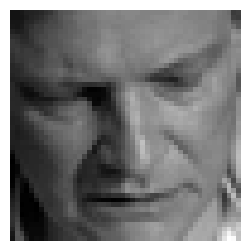

In [ ]:
index_image = 1450
visualize_image(X_train[index_image])
print("Emotion is: {}".format(emotions[Y_train[index_image]]))

In [ ]:
import tensorflow.keras as keras

# instantiate the model
input = keras.Input(shape=(48, 48, 1), name="input")
model = keras.layers.Conv2D(32, (3, 3), activation='relu')(input)
model = keras.layers.Conv2D(64, (3, 3), activation='relu')(model)
model = keras.layers.MaxPooling2D((2, 2))(model)
model = keras.layers.Conv2D(64, (3, 3), activation='relu')(model)
model = keras.layers.Conv2D(128, (3, 3), activation='relu')(model)
model = keras.layers.MaxPooling2D((2, 2))(model)
model = keras.layers.Conv2D(128, (3, 3), activation='relu')(model)
model = keras.layers.Conv2D(256, (3, 3), activation='relu')(model)
model = keras.layers.MaxPooling2D((2, 2))(model)
model = keras.layers.Flatten()(model)
dropout = keras.layers.Dropout(0.8)(model)
dense = keras.layers.Dense(32, activation='relu')(dropout)
output = keras.layers.Dense(1, activation='sigmoid')(dense)
model = keras.Model(input, output)

In [ ]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 conv2d_13 (Conv2D)          (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 20, 20, 64)        36928     
                                                                 
 conv2d_15 (Conv2D)          (None, 18, 18, 128)       73856     
                                                           

In [ ]:
import os
model_dir = "models/"
experiment = "binary_FER_cnn_3.h5"
save_path = os.path.join(model_dir, experiment)

callbacks_list = [
    # this callback saves the model that has the lowest validation loss during the training
    keras.callbacks.ModelCheckpoint(
      filepath=save_path,
      monitor="val_loss",
      verbose=1,
      save_best_only=True),
    
    # this reduces learning rate when validation loss is not decreasing
    keras.callbacks.ReduceLROnPlateau(verbose=1, patience=2, factor=0.8)
]

In [ ]:
history = model.fit(
    X_train,
    Y_train,
    batch_size=32,
    epochs=30,
    validation_data=(X_val,Y_val),
    callbacks = callbacks_list
)

Epoch 1/30
502/502 [==============================] - ETA: 0s - loss: 0.8042 - accuracy: 0.5393
Epoch 1: val_loss improved from inf to 0.66424, saving model to models/binary_FER_cnn_3.h5
502/502 [==============================] - 305s 605ms/step - loss: 0.8042 - accuracy: 0.5393 - val_loss: 0.6642 - val_accuracy: 0.5565 - lr: 0.0010
Epoch 2/30
502/502 [==============================] - ETA: 0s - loss: 0.6750 - accuracy: 0.5915
Epoch 2: val_loss improved from 0.66424 to 0.64617, saving model to models/binary_FER_cnn_3.h5
502/502 [==============================] - 306s 609ms/step - loss: 0.6750 - accuracy: 0.5915 - val_loss: 0.6462 - val_accuracy: 0.6456 - lr: 0.0010
Epoch 3/30
502/502 [==============================] - ETA: 0s - loss: 0.5775 - accuracy: 0.7060
Epoch 3: val_loss did not improve from 0.64617
502/502 [==============================] - 306s 610ms/step - loss: 0.5775 - accuracy: 0.7060 - val_loss: 0.6492 - val_accuracy: 0.6777 - lr: 0.0010
Epoch 4/30
502/502 [===============

In [ ]:
# evaluate the model produced at the end of the training (not the best, validation loss is high)
model.evaluate(X_test, Y_test)

63/63 [==============================] - 18s 278ms/step - loss: 1.9681 - accuracy: 0.8893


[1.9681059122085571, 0.8893300294876099]

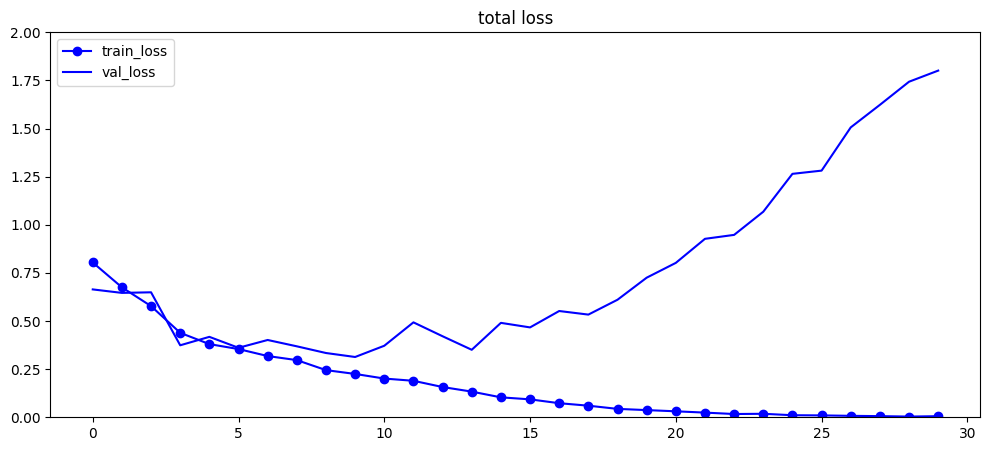

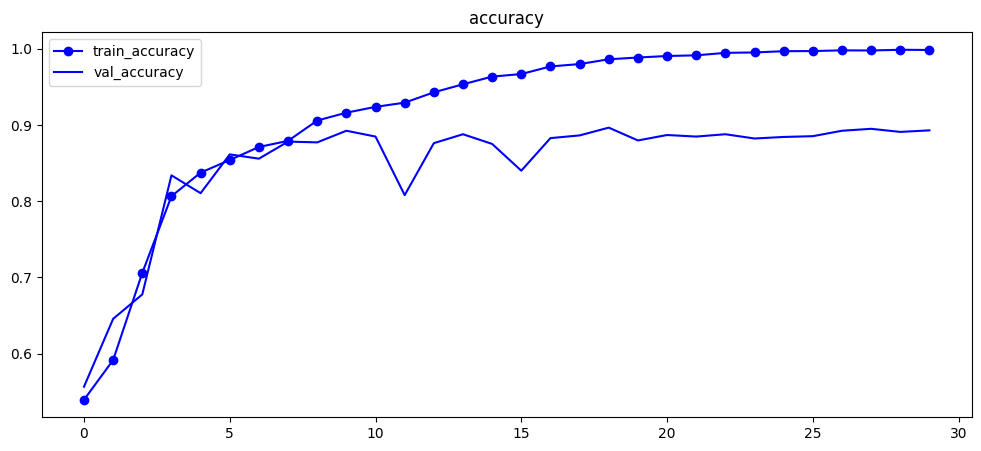

In [ ]:
plt.figure(figsize=(12,5))
plt.title('total loss')
plt.plot(history.history['loss'],'bo-',label = 'train_loss')
plt.plot(history.history['val_loss'],'b-',label = 'val_loss')
plt.ylim(0,2)
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.title('accuracy')
plt.plot(history.history['accuracy'],'bo-',label = 'train_accuracy')
plt.plot(history.history['val_accuracy'],'b-',label = 'val_accuracy')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

# delete the current model
del model

# load the model saved by the early stopping callback
model = load_model(os.path.join(model_dir, experiment))

#evaluate the model on the test set (low validation loss)
model.evaluate(X_test, Y_test)

63/63 [==============================] - 8s 124ms/step - loss: 0.3150 - accuracy: 0.8913


[0.3150006830692291, 0.8913151621818542]

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# create and plot the confusion matrix
predictions = model(X_test)

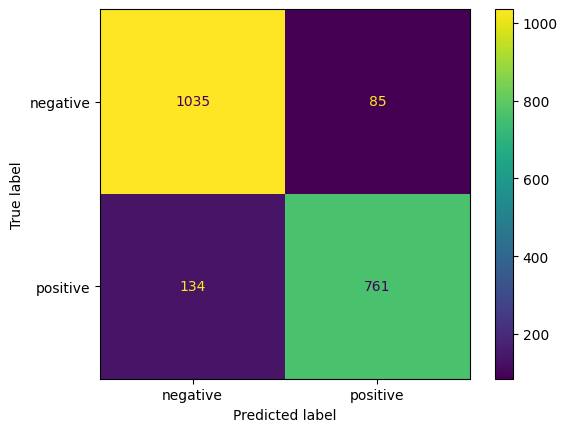

In [ ]:
result = confusion_matrix(Y_test, np.around(predictions))
disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=['negative', 'positive'])
disp.plot()
plt.show()

In [ ]:
# check prediction against true label
index_image = 85
sample = np.expand_dims(X_test[index_image], axis=0)
visualize_image(X_test[index_image])
print("True emotion is: {}".format(emotions[Y_test[index_image]]))
print("Prediction is: {}".format(model(sample, training=False)))

In [ ]:
# save the model to google drive
!cp ./models/binary_FER_cnn_3.h5 /content/drive/MyDrive/